# Evaluating inferred network using the Gold Standard data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#Import Gld_Std.tsv, gold standard interactions
gold_std = pd.read_csv('Gld_Std.tsv', sep='\t')

In [3]:
#Import importances_tf_allgenes.csv, matrix of importances
importances = np.genfromtxt('importances_tf_allgenes.csv',delimiter=',')

#Turns importances_tf_allgenes.csv into an sorted list, from most important interactions to least
ordered_connections = []
for j in range(4511):
    for w in range(334):
        index = (importances[j,w],j+1,w+1)
        ordered_connections.append(index)
        
ordered_connections.sort(key=lambda x: x[0])
ordered_connections.reverse()
ordered_conn = np.array(ordered_connections)

#Define sections of gold standard data corresponding to pos (experimentally determined connections) and neg (experimentally determined lack of connection)
pos = gold_std[:2066].to_numpy()
neg = gold_std[2067:].to_numpy()

In [4]:
#Binary search function for determining if a member of ordered_connections is in pos or neg
def bin_search(a, gene1, tf):
    low = 0
    high = len(a) - 1
    mid = 0
    found = False
    while low <= high: 
  
        mid = (high + low) // 2
  
        # Check if x is present at mid 
        if int((a[mid,1])[1:])==tf: 
            index = mid
            found = True
            break
  
        # If x is greater, ignore left half 
        elif int((a[mid,1])[1:]) > tf: 
            high = mid - 1
  
        # If x is smaller, ignore right half 
        else: 
            low = mid + 1
    if found == False:
        return False
    else:
        while int((a[index,1])[1:])==tf:
            if index==0:
                break
            else:
                index-=1

        if not(int((a[index,1])[1:])==tf):
            index+=1
        while True:
            if index == len(a) or not(int((a[index,1])[1:])==tf):
                return False
            elif int((a[index,0])[1:]) == gene1:
                return True
            index+=1

In [5]:
#p is number of positives in gold standard data
p = 2066
#n is number of negatives
n = 152280-2066

In [6]:
#Loop to construct PR and ROC Curve data. 
#March down ordered_connections, find if is in either pos or neg gold standard data
#Increment truepos or falsepos accordingly. 
PR = []
ROC = []
truepos = 0
falsepos = 0
for i,a in enumerate(ordered_conn):
    info = False
    gene1 = a[1]
    tf1 = a[2]
    if bin_search(pos,tf1,gene1):
        truepos+=1
        info = True
    elif bin_search(neg,tf1,gene1):
        falsepos+=1
        info = True
    else:
        pass
    if info ==True:
        tp_rate = truepos/p
        fp_rate = falsepos/(n)
        precision = truepos/(truepos+falsepos)
        ROC.append([fp_rate,tp_rate])
        PR.append([tp_rate,precision])

In [7]:
#Upload large_trainingset_ROC.csv. This corresponds to the first strategy where all gene expressions were used as training data.
#This data can be made using the same code, all you have to do is change in import process (different file, "importances_all.csv", and change loop indicies.) 
all_ROC = np.array(pd.read_csv('large_trainingset_ROC.csv', sep=','))
all_PR = np.array(pd.read_csv('large_trainingset_PR.csv', sep=','))

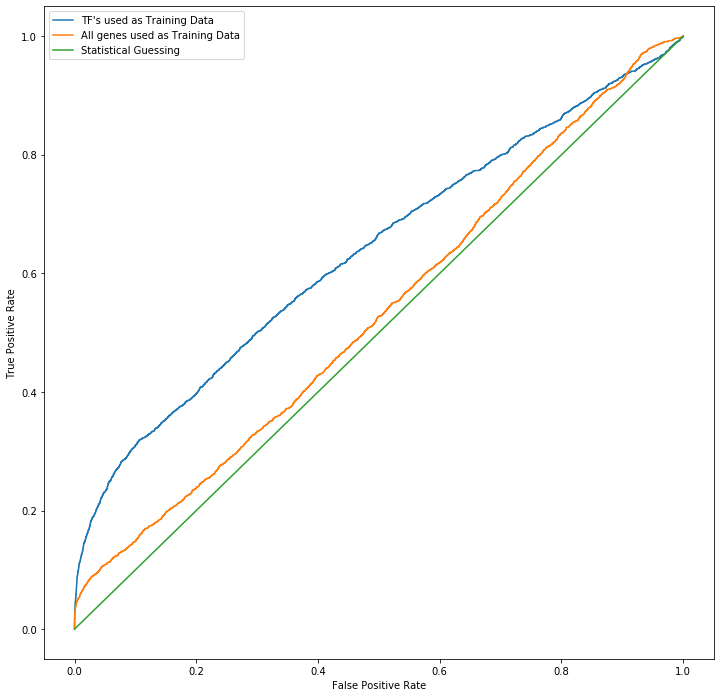

In [12]:
ROC = np.array(ROC)
plt.plot(ROC[:,0],ROC[:,1])
plt.plot(all_ROC[:,0],all_ROC[:,1])
plt.plot(ROC[:,0],ROC[:,0])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(["TF's used as Training Data","All genes used as Training Data","Statistical Guessing"])
plt.rcParams["figure.figsize"] = (12,12)

In [9]:
#Display area under ROC of both approaches
print(np.trapz(ROC[:,1], x=ROC[:,0]))
print(np.trapz(all_ROC[:,1], x=all_ROC[:,0]))

0.6351966418841678
0.5318727308832878


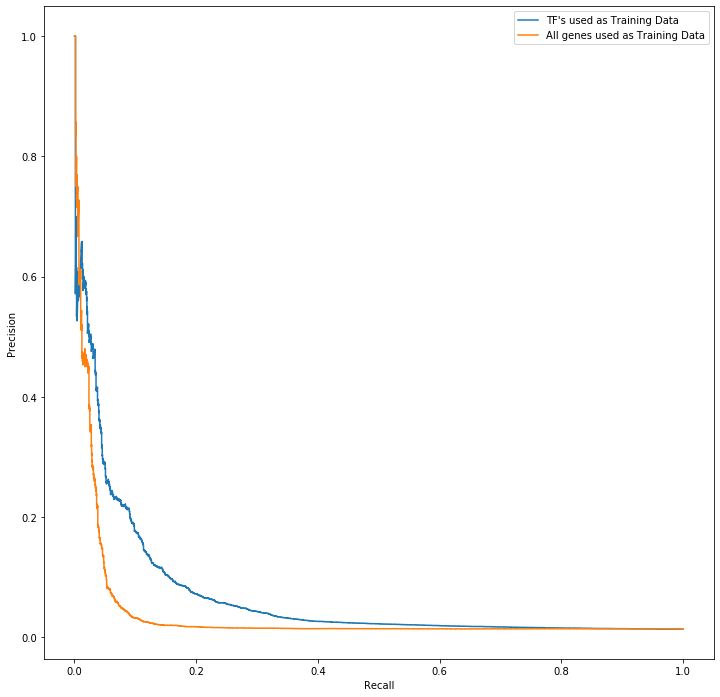

In [10]:
#Plot both approaches in PR plot
PR = np.array(PR)
plt.plot(PR[:,0],PR[:,1])
plt.plot(all_PR[:,0],all_PR[:,1])
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend(["TF's used as Training Data","All genes used as Training Data"])
plt.rcParams["figure.figsize"] = (12,12)

In [11]:
#Display AUPR of both approaches
print(np.trapz(PR[:,1], x=PR[:,0]))
print(np.trapz(all_PR[:,1], x=all_PR[:,0]))

0.067192296670843
0.03595616734172315
